In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

from torch.utils.data import DataLoader, TensorDataset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [4]:
import os

pwd = os.getcwd()

In [5]:
df = pd.read_csv(pwd + '\merged_data.csv')
df.head()

,date,Open,Close,Change,majority_sentiment,average_sentiment
0,2025-02-28,3913.54,3915.439,0.048601,2,0.890644
1,2025-02-27,3908.73,3913.537,0.122904,2,0.954200
2,2025-02-26,3910.01,3908.733,-0.032736,0,0.812788
3,2025-02-25,3920.37,3910.013,-0.264057,2,0.835742
4,2025-02-24,3883.52,3920.365,0.948727,2,0.809047


In [6]:
df.columns

Index(['date', 'Open', 'Close', 'Change', 'majority_sentiment',
       'average_sentiment'],
      dtype='object')

In [7]:

# Convert 'Date' column to datetime objects if it's not already
df['date'] = pd.to_datetime(df['date'])

# Select features and target variable
features = ['Open', 'Change'] # Add more relevant features
target = 'Close'

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [8]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  # Target is the last column (Close price)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10 # Adjust the sequence length as needed
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with one neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1) #Adjust epochs and batch size


# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)


Epoch 1/200
25/25 [==============================] - 4s 7ms/step - loss: 0.0227
Epoch 2/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 3/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 4/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 5/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 6/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 7/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 8/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 9/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 10/200
25/25 [==============================] - 0s 6ms/step - loss: 9.7819e-04
Epoch 11/200
25/25 [==============================] - 0s 7ms/step - loss: 8.3972e-04
Epoch 12/200
25/25 [==============================] - 0s 7ms/step - loss: 7.2942e-04
Epoch 13/200
25/25 [=====

7/7 [==============================] - 1s 3ms/step
Test Loss (MSE): 0.00016734858218114823
Mean Absolute Error (MAE): 17.48730960910821
R-squared (R2): 0.9502888655430035


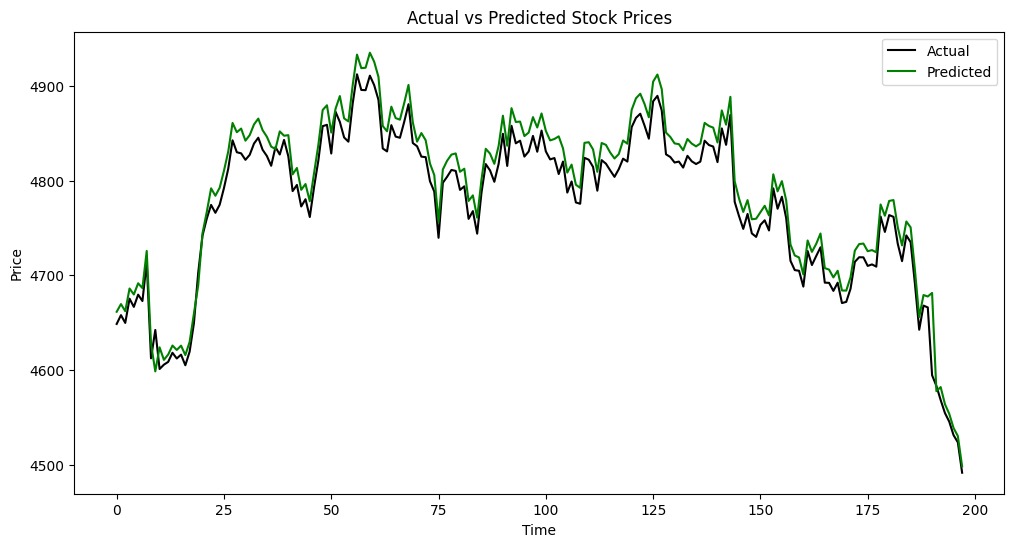

In [10]:
import matplotlib.pyplot as plt

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual prices
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Calculate R-squared (R2)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print the results
print(f"Test Loss (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', color='black')
plt.plot(y_pred_actual, label='Predicted', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

Epoch 1/200
25/25 [==============================] - 3s 8ms/step - loss: 0.0161
Epoch 2/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 3/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 4/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 5/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 6/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 7/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 8/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 9/200
25/25 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 10/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 11/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 12/200
25/25 [==============================] - 0s 6ms/step - loss: 9.5274e-04
Epoch 13/200
25/25 [=============

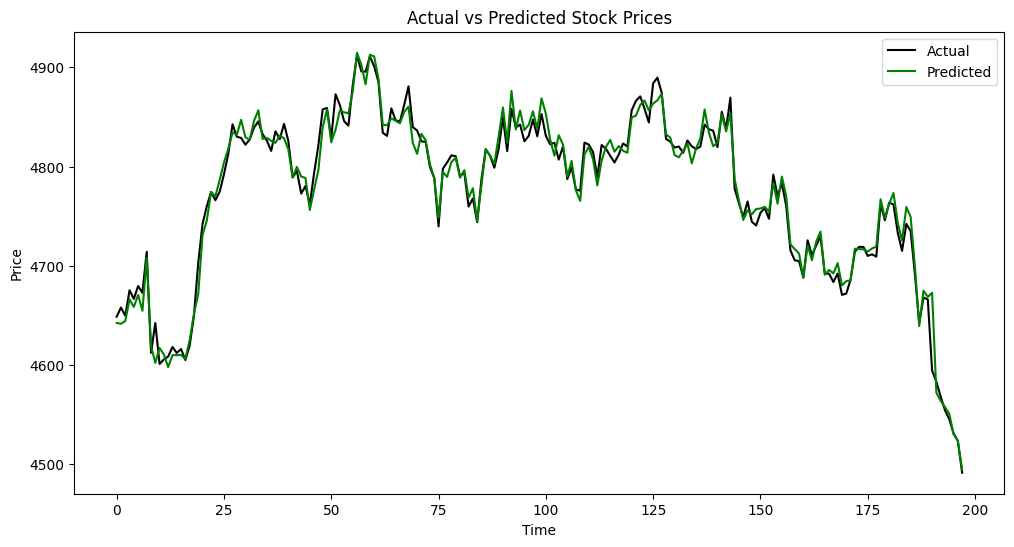

In [13]:
features = ['Open', 'Change', 'majority_sentiment', 'average_sentiment'] # Add more relevant features
target = 'Close'

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  # Target is the last column (Close price)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10 # Adjust the sequence length as needed
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with one neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1) #Adjust epochs and batch size


# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)


import matplotlib.pyplot as plt

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual prices
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Calculate R-squared (R2)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print the results
print(f"Test Loss (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', color='black')
plt.plot(y_pred_actual, label='Predicted', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()